# Sentiment Analysis on Movie Reviews 
#### Problem of Sequance Classification 
Classifying whether a review is positive or negative and other 3 categories

### Kaggle competition link
Classify the sentiment of sentences from the Rotten Tomatoes dataset.
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/submissions?sortBy=date&group=all&page=1

In [2]:
import numpy as np

import h5py
import keras

from keras.utils import np_utils

from keras.models import model_from_yaml

from keras.models import Sequential

from keras.layers import LSTM, Dense, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding

from keras.preprocessing import sequence

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

# download nltk assets
#import nltk
#nltk.download()

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(7)

Using Theano backend.


In [4]:
# reading rotten tomatoes train data
train_data = pd.read_csv("train.tsv", sep='\t')
test_data = pd.read_csv("test.tsv", sep='\t')

In [5]:
# inspect the training data
train_data.info()
# losing the phrase and sentance id
train_data_i = train_data.drop(['PhraseId', 'SentenceId'], axis=1)
# taking a look at the data  
print(train_data_i.head())
# counting number of phrases in every sentiment type
print(train_data_i.groupby(('Sentiment')).count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
                                              Phrase  Sentiment
0  A series of escapades demonstrating the adage ...          1
1  A series of escapades demonstrating the adage ...          2
2                                           A series          2
3                                                  A          2
4                                             series          2
           Phrase
Sentiment        
0            7072
1           27273
2           79582
3           32927
4            9206


           Phrase  index
Sentiment               
0            7072      0
1           27273      1
2           79582      2
3           32927      3
4            9206      4


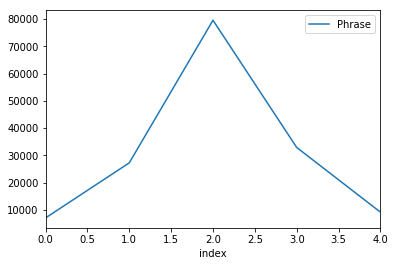

In [6]:
# visualizing how much the data is biased towards certain sentiment
sentiment_count = train_data_i.groupby(('Sentiment')).count()
sentiment_count['index'] = range(0, 5)
print(sentiment_count)
sentiment_count.plot(x='index', y='Phrase')

In [7]:
# raw data 
raw_docs_train = train_data['Phrase'].values
raw_docs_test = test_data['Phrase'].values
sentiment_train = train_data['Sentiment'].values
num_labels = len(np.unique(sentiment_train))

In [8]:
#text pre-processing
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stemmer = SnowballStemmer('english')

print ("pre-processing train docs...")
processed_docs_train = []
for doc in raw_docs_train:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_train.append(stemmed)

print ("pre-processing test docs...")
processed_docs_test = []
for doc in raw_docs_test:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_test.append(stemmed)

processed_docs_all = np.concatenate((processed_docs_train, processed_docs_test), axis=0)


pre-processing train docs...
pre-processing test docs...


In [9]:
dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())
print ("dictionary size: ", dictionary_size)
#dictionary.save('dictionary.dict')
#corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print ("converting to token ids...")
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_train.append(word_ids)
    word_id_len.append(len(word_ids))

word_id_test, word_ids = [], []
for doc in processed_docs_test:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_test.append(word_ids)
    word_id_len.append(len(word_ids))

seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
word_id_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
word_id_test = sequence.pad_sequences(np.array(word_id_test), maxlen=seq_len)
y_train_enc = np_utils.to_categorical(sentiment_train, num_labels)

dictionary size:  13759
converting to token ids...


In [10]:
# model define
embedding_vector_length = 128

model = Sequential()

model.add(Embedding(dictionary_size, embedding_vector_length))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, kernel_initializer='uniform', padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(100))

model.add(Dense(num_labels, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1761152   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,827,177
Trainable params: 1,827,177
Non-trainable params: 0
_________________________________________________________________


In [3]:
# load YAML and create model
yaml_file = open('rotten_model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)

# load weights into new model
model.load_weights("rotten_weights.h5")
print("Loaded model from disk")

OSError: Unable to open file (Unable to open file: name = 'rotten_weights.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [11]:
# fit model start training 
#     model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64, verbose=1)
model.fit(word_id_train, y_train_enc, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
156060/156060 [==============================] - 223s - loss: 1.0596 - acc: 0.5754   
Epoch 2/20
156060/156060 [==============================] - 232s - loss: 0.8460 - acc: 0.6512   
Epoch 3/20
156060/156060 [==============================] - 228s - loss: 0.7808 - acc: 0.6756   
Epoch 4/20
156060/156060 [==============================] - 226s - loss: 0.7437 - acc: 0.6905   
Epoch 5/20
156060/156060 [==============================] - 226s - loss: 0.7156 - acc: 0.7037   
Epoch 6/20
156060/156060 [==============================] - 227s - loss: 0.6933 - acc: 0.7115   
Epoch 7/20
156060/156060 [==============================] - 227s - loss: 0.6742 - acc: 0.7174   
Epoch 8/20
156060/156060 [==============================] - 236s - loss: 0.6562 - acc: 0.7248   
Epoch 9/20
156060/156060 [==============================] - 242s - loss: 0.6421 - acc: 0.7309   
Epoch 10/20
156060/156060 [==============================] - 240s - loss: 0.6301 - acc: 0.7335   
Epoch 11/20
156060/156060 [==

In [12]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("rotten_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("rotten_weights.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
# can not evaluate because do not have the y_test
# # Final evaluation of the model
# scores = model.evaluate(word_id_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

test_pred = model.predict_classes(word_id_test)

#make a submission
test_data['Sentiment'] = test_pred.reshape(-1,1) 
header = ['PhraseId', 'Sentiment']
test_data.to_csv('./lstm_sentiment.csv', columns=header, index=False, header=True)

66272/66292 [============================>.] - ETA: 0s